# Лабораторная работа № 2 по курсу ML.
### Выполнил: Салихов Тимур, группа М8О-312Б-22

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TRAIN_FILE_PATH = './nyc-taxi-trip-duration/train.csv'
VALIDATION_FILE_PATH = './nyc-taxi-trip-duration/test.csv'
SUBMISSION1_FILE_PATH = './submission1.csv'
SUBMISSION2_FILE_PATH = './submission2.csv'
LASSO1_FILE_PATH = './submission1_lasso.csv'
LASSO2_FILE_PATH = './submission2_lasso.csv'
RIDGE1_FILE_PATH = './submission1_ridge.csv'
RIDGE2_FILE_PATH = './submission2_ridge.csv'

## Подготовка данных

Загрузим наш датасет

In [184]:
train_df = pd.read_csv(TRAIN_FILE_PATH)
train_df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


Проанализируем столбцы таблицы и попробуем извлечь из нее признаки.

1. Столбец ```id``` для нас бесполезен, можем от него избавиться,
2. ```vendor_id``` напротив может нам быть полезен, оставим его как категориальный признак,
3. Из столбца ```pickup_datetime`` можем извлечь день, месяц, день недели, время в часах и время в минутах,
4. ```dropoff_datetime``` не будет присутствовать в подаваемых нам данных, поэтому его можно игнорировать,
5. ```passenger_count``` может также быть использован как категориальный признак,
6. Из данных ```pickup_latitude```, ```pickup_longitude```, ```dropoff_latitude```, ```dropoff_longitude``` можем найти расстояние между точками посадки и высадки. Данный подсчет можно проводить двумя методами:

    1. Манхеттенское расстояние,
    2. Метод великой окружности,

7. ```store_and_fwd_flag``` также является бинарным категориальным признаком.

Для рассчета манхеттенского расстояния нам понадобится вспомогательная функция ```pd_manhattan_distance()```. Она принимает на вход ```DataFrame``` и добавляет к нему столбец ```distance```.

In [185]:
def pd_manhattan_distance(df: pd.DataFrame) -> pd.DataFrame:
    df['distance'] = np.abs(df['dropoff_latitude'] - df['pickup_latitude']) * 111.32 + \
                            np.abs(df['dropoff_longitude'] - df['pickup_longitude']) * 111.32 * \
                            np.cos(df['pickup_latitude'] * np.pi / 180)

    return df

Для расчета великой окружности нам понадобится вспомогательная функция ```pd_great_circle()```. Она принимает на вход ```DataFrame```, рассчитывает расстояние при помощи функции ```great_circle()``` из библиотеки ```geopy``` и добавляет столбец ```distance``` к датафрейму.

In [186]:
from geopy.distance import great_circle

def pd_great_circle(df: pd.DataFrame) -> pd.DataFrame:
    df['distance'] = df.apply(lambda row: great_circle(
        (row['pickup_latitude'], row['pickup_longitude']), 
        (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km, axis=1)
    
    return df

Теперь мы можем составить функцию ```feature_generator()```, которая позволит нам генерировать фичи из исходных данных, а затем удалять ненужные столбцы. Среди параметров функции присутствует ```dist_calc```, который позволяет нам считать расстояние разными способами.

In [187]:
def feature_generator(df: pd.DataFrame, dist_calc: callable) -> pd.DataFrame:
    output_df = df.copy()

    # Extracting time features
    output_df['pickup_datetime'] = pd.to_datetime(output_df['pickup_datetime'])
    output_df['day'] = output_df['pickup_datetime'].dt.day
    output_df['month'] = output_df['pickup_datetime'].dt.month
    output_df['day_week'] = output_df['pickup_datetime'].dt.day_of_week
    output_df['hours'] = output_df['pickup_datetime'].dt.hour
    output_df['minutes'] = output_df['pickup_datetime'].dt.minute

    # Calculating distance
    dist_calc(output_df)

    # Transforming string values in store_and_fwd_flag to bool values
    output_df['store_and_fwd_flag'] = output_df['store_and_fwd_flag'] == 'Y'
    
    # Dropping unused columns
    unused = ['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 
              'dropoff_longitude', 'dropoff_latitude']
    
    output_df = output_df.drop(columns=unused)

    return output_df
    

Теперь применим функцию к исходным данным и посмотрим на результат

In [244]:
train_df1 = feature_generator(train_df, pd_manhattan_distance)
train_df1

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day,month,day_week,hours,minutes,distance
0,2,1,False,455,14,3,0,17,24,1.737385
1,1,1,False,663,12,6,6,0,43,2.433240
2,2,1,False,2124,19,1,1,11,35,8.212803
3,2,1,False,429,6,4,2,19,32,1.663200
4,2,1,False,435,26,3,5,13,30,1.200806
...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,False,778,8,4,4,13,31,1.667769
1458640,1,1,False,655,10,1,6,7,35,8.067645
1458641,2,1,False,764,22,4,4,6,57,10.657620
1458642,1,1,False,373,5,1,1,15,56,1.523562


In [189]:
train_df2 = feature_generator(train_df, pd_great_circle)
train_df2

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day,month,day_week,hours,minutes,distance
0,2,1,False,455,14,3,0,17,24,1.498523
1,1,1,False,663,12,6,6,0,43,1.805510
2,2,1,False,2124,19,1,1,11,35,6.385108
3,2,1,False,429,6,4,2,19,32,1.485501
4,2,1,False,435,26,3,5,13,30,1.188590
...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,False,778,8,4,4,13,31,1.225082
1458640,1,1,False,655,10,1,6,7,35,6.049844
1458641,2,1,False,764,22,4,4,6,57,7.824617
1458642,1,1,False,373,5,1,1,15,56,1.092565


Мы извлекли всю нужную информацию и избавились от ненужных столбцов. Однако теперь необходимо проанализировать наши данные на выбросы, чтобы исключить их из выборки, тем самым повысив ее качество.

Напишем вспомогательную функцию ```draw_boxenplot()```, которая позволит визуализировать выбросы в числовых признаках

In [224]:
def draw_boxexplot(data: pd.DataFrame, columns: list[str]) -> None:
    _, ax = plt.subplots(figsize=(10, 6 * len(columns)), nrows=len(columns))

    if len(columns) == 1:
        sns.boxenplot(data[columns[0]], ax=ax)
    else:
        for i in range(len(columns)):
            sns.boxenplot(data[columns[i]], ax=ax[i])
            
    plt.show()

Теперь опреелим функцию ```remove_outliers```, которая поможет нам избавиться от выбросов

In [243]:
def remove_outliers(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    for col in columns:
        Q1 = data[col].quantile(0.1)
        Q99 = data[col].quantile(0.9)

        outliers = data[(data[col] < Q1) | (data[col] > Q99)]

        data = data.drop(outliers.index)
    
    return data
        

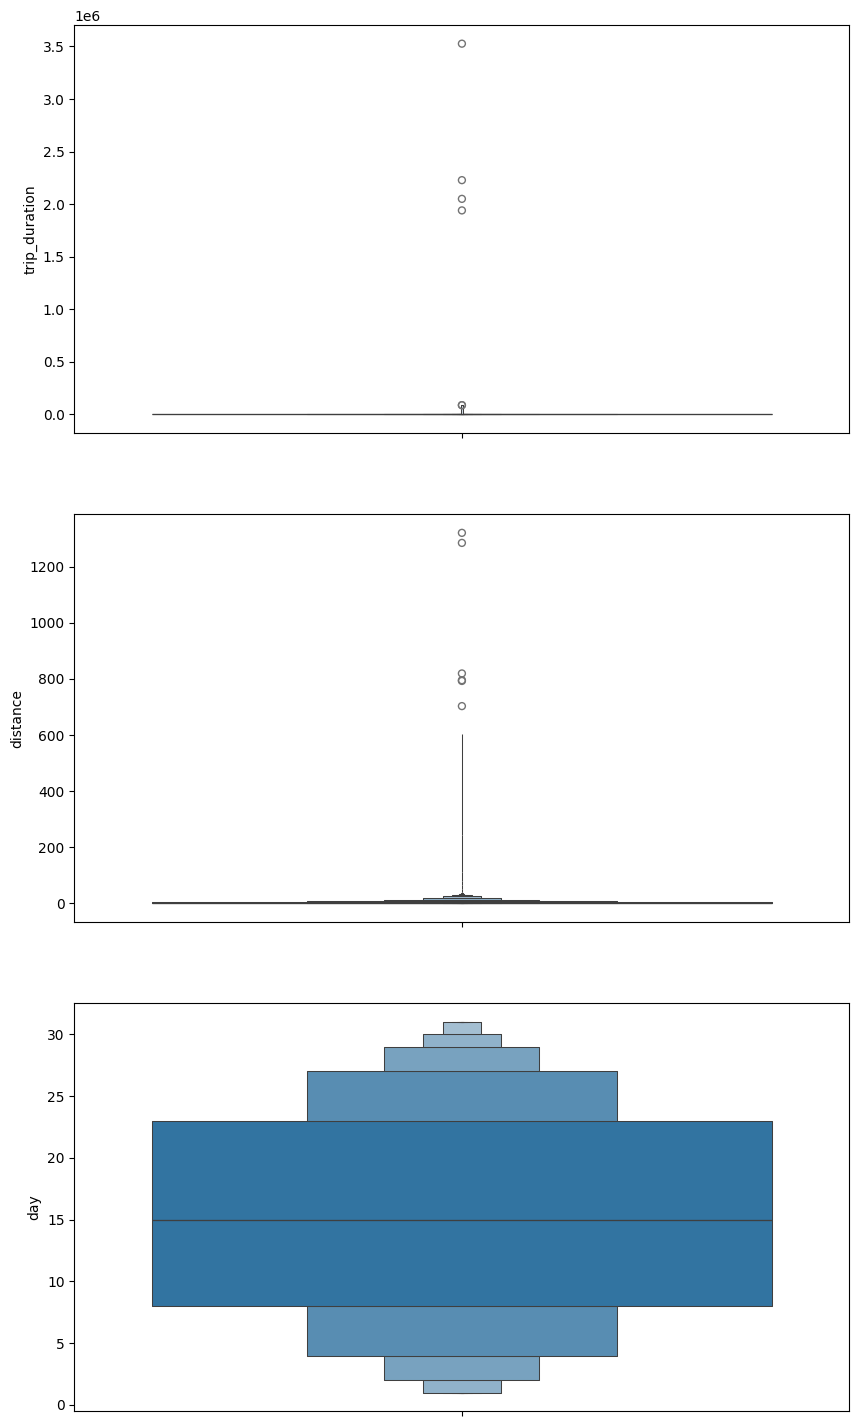

In [245]:
draw_boxexplot(train_df1, ['trip_duration', 'distance', 'day'])

In [246]:
train_df1 = remove_outliers(train_df1, ['trip_duration', 'distance', 'day'])

train_df1

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day,month,day_week,hours,minutes,distance
0,2,1,False,455,14,3,0,17,24,1.737385
1,1,1,False,663,12,6,6,0,43,2.433240
3,2,1,False,429,6,4,2,19,32,1.663200
4,2,1,False,435,26,3,5,13,30,1.200806
6,1,4,False,341,17,6,4,22,34,1.876009
...,...,...,...,...,...,...,...,...,...,...
1458632,2,2,False,777,6,3,6,11,4,5.243942
1458633,1,3,False,979,17,3,3,19,10,4.063143
1458637,1,1,False,760,17,4,6,18,48,4.971907
1458639,2,4,False,778,8,4,4,13,31,1.667769


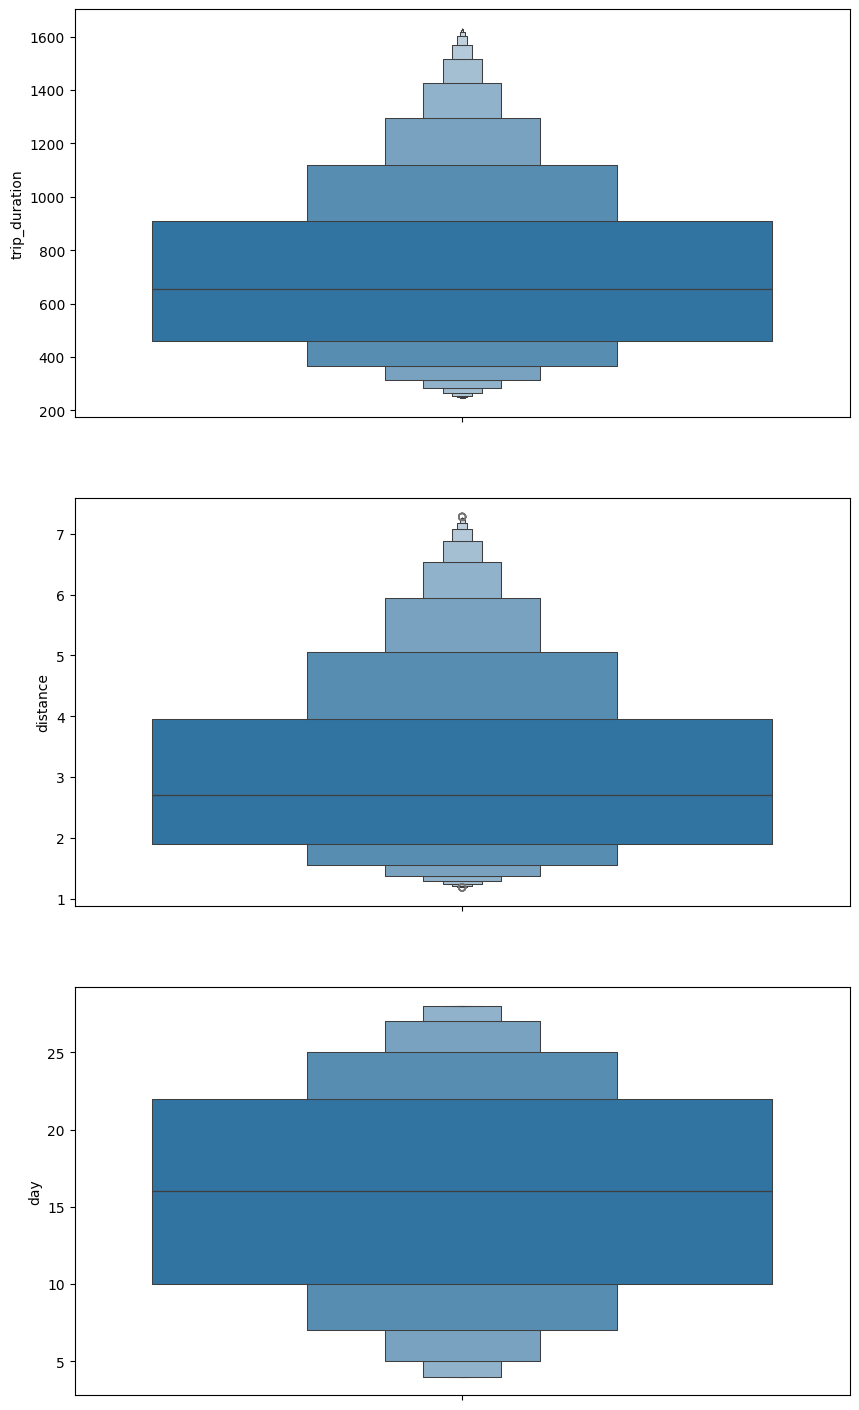

In [247]:
draw_boxexplot(train_df1, ['trip_duration', 'distance', 'day'])

In [248]:
def data_cleaner(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

    df = df[(df['trip_duration'] >= 5 * 60) & (df['trip_duration'] <= 4 * 60 * 60)]

    df = df[(df['distance'] >= 0.5) & (df['distance'] <= 80)]

    df = df[(df['distance'] / df['trip_duration'] * 60 * 60 >= 15) &
            (df['distance'] / df['trip_duration'] * 60 * 60 <= 60)]
    
    df['distance'] = np.log(df['distance'])
    
    return df

In [140]:
train_df1 = data_cleaner(train_df1)
train_df2 = data_cleaner(train_df2)

train_df1

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,day,month,day_week,hours,minutes,distance
6,1,4,False,341,17,6,4,22,34,0.629147
7,2,1,False,1551,21,5,5,7,54,2.090353
9,2,1,False,1225,10,3,3,21,45,1.751052
11,2,4,False,1128,15,5,6,11,16,1.669519
14,2,1,False,1414,27,5,4,0,43,2.040723
...,...,...,...,...,...,...,...,...,...,...
1458634,1,2,False,972,3,4,6,13,51,1.937647
1458637,1,1,False,760,17,4,6,18,48,1.603803
1458638,2,5,False,414,2,2,1,0,39,0.853919
1458640,1,1,False,655,10,1,6,7,35,2.087862


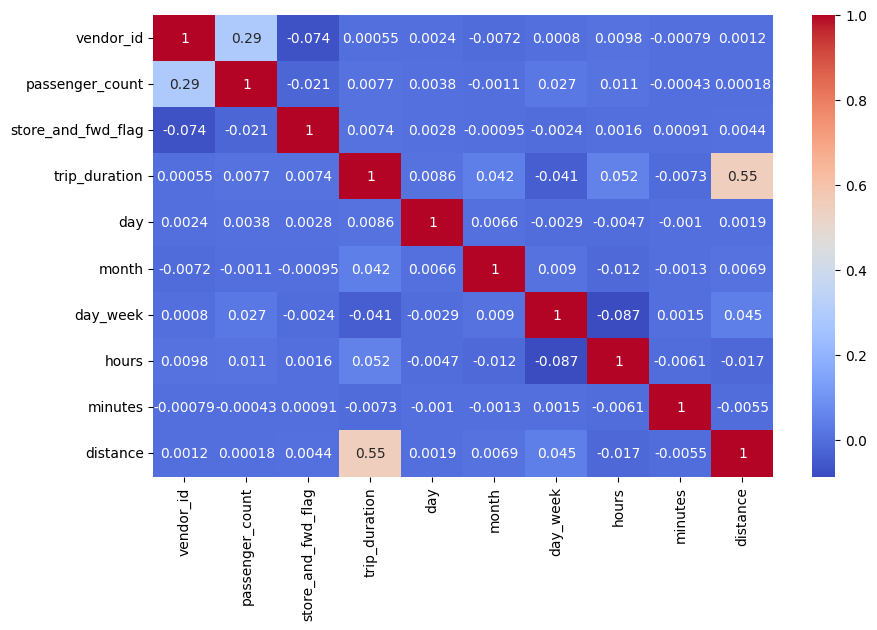

In [249]:
_, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(train_df1.corr(), cmap='coolwarm', annot=True, ax=ax)
plt.show()

In [250]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import LeaveOneOutEncoder

categorical_features = ['vendor_id', 
                        'passenger_count', 
                        'store_and_fwd_flag', 
                        'month', 
                        'day_week'
                        ]

numeric_features = ['day',
                    'hours',
                    'minutes',
                    'distance'
                    ]


ct = ColumnTransformer([
    ('loo', LeaveOneOutEncoder(), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

In [251]:
from sklearn.model_selection import train_test_split

y1 = train_df1['trip_duration']
X1 = train_df1.drop(columns='trip_duration')

y2 = train_df2['trip_duration']
X2 = train_df2.drop(columns='trip_duration')

X1 = ct.fit_transform(X1, y1)
X2 = ct.fit_transform(X2, y2)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

In [252]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)

In [264]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

print('1st RMSE score:', root_mean_squared_error(y1_test, y1_pred))
print('R2 score:', r2_score(y1_test, y1_pred))
print('2nd RMSE score:', root_mean_squared_error(y2_test, y2_pred))
print('R2 score:', r2_score(y2_test, y2_pred))
print('MAE score:', mean_absolute_error(y1_test, y1_pred))

1st RMSE score: 262.2870496445343
R2 score: 0.3091620339580009
2nd RMSE score: 3031.8539979930206
R2 score: 0.028870554011182326
MAE score: 206.91043329885545
